# rfClassifier

The following changes have been made to Calvin's original code: 
- Addition of `SMOTE`
- Switch to `GradientBoostingClassifier`
- Parameter tuning using `RandomizedSearchCV`
- Additional metrics summarized and/or plotted

In [1]:
# environment
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import time
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Functions
### Plotting

In [2]:
# plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, save_path=None):
    """
    Plot and save confusion matrix.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")
    plt.close()

In [3]:
# plot roc curve
def plot_roc_curve(y_true, y_pred_proba, save_path=None):
    """
    Plot and save ROC curve.
    """
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    if save_path:
        plt.savefig(save_path)
        print(f"ROC curve saved to {save_path}")
    plt.close()


In [4]:
# plot precision recall curve
def plot_precision_recall_curve(y_true, y_pred_proba, save_path=None):
    """
    Plot and save Precision-Recall curve.
    """
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred_proba[:, 1])
    pr_auc = metrics.auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    
    if save_path:
        plt.savefig(save_path)
        print(f"Precision-Recall curve saved to {save_path}")
    plt.close()


In [5]:
# plot learning curves
def plot_learning_curves(estimator, X, y, save_path=None):
    """
    Plot and save learning curves.
    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.plot(train_sizes, val_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel('Training Examples')
    plt.ylabel('F1 Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
        print(f"Learning curves saved to {save_path}")
    plt.close()


In [6]:
# plot feature importance
def plot_feature_importance(feature_importance, feature_names, save_path=None):
    """
    Plot and save feature importance.
    """
    plt.figure(figsize=(12, 6))
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    sns.barplot(x='importance', y='feature', data=importance_df.head(20))
    plt.title('Top 20 Most Important Features')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    
    if save_path:
        plt.savefig(save_path)
        print(f"Feature importance plot saved to {save_path}")
    plt.close()


In [7]:
# plot cross-validation scores
def plot_cv_scores(cv_scores, save_path=None):
    """
    Plot and save cross-validation scores distribution.
    """
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=cv_scores)
    plt.title('Cross-validation Scores Distribution')
    plt.xlabel('F1 Score')
    
    if save_path:
        plt.savefig(save_path)
        print(f"CV scores distribution saved to {save_path}")
    plt.close()


## Data prep

In [8]:
# data loading
def load_data(data_file):
    '''
    load_data()

    Loads data from CSV file.
    
    --------
    Args:

    data_file: (Type: String) Name of CSV file containing data
    --------
    Returns:

    features: (Type: numpy.ndarray) Features of the dataset.
    labels: (Type: numpy.ndarray) Labels of the dataset
    feature_names: (Type: list) Names of the features
    '''
    print(f"Loading data from {data_file}...")
    # Read the CSV file using pandas
    df = pd.read_csv(data_file)

    # Extract feature names from the first row
    feature_names = df.columns.tolist()[1:]  # Skip the 'Label' column
    print(f"\nFeature names: {feature_names[:5]}... (total: {len(feature_names)} features)")
    
    # First column is the target variable, features are all other columns
    y = df.iloc[:, 0].values    # First column
    X = df.iloc[:, 1:].values   # All columns except the first one
    
    print(f"Loaded {X.shape[0]} samples with {X.shape[1]} features")
    print("Class distribution before SMOTE:")
    unique, counts = np.unique(y, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"Class {label}: {count} samples")
    
    return X, y, feature_names


In [9]:
# saving model parameters
def save_results(results, filename=None):
    '''
    Save model results to a JSON file.
    
    --------
    Args:
    results: (Type: dict) Dictionary containing model results
    filename: (Type: str) Optional filename, defaults to timestamp
    '''
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"model_results_{timestamp}.json"
    
    with open(filename, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Results saved to {filename}")

## Analysis

In [10]:
def main(file):
    start_time = time.time()
    
    # Set Random Seed for Reproducability
    np.random.seed(32)

    # Load Data
    X, y, feature_names = load_data(file)

    # Generate train and test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"\nTraining set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

    # Check the number of minority class samples in the training set
    minority_class_count = np.sum(y_train == 1)
    print(f"Number of minority class samples in training set: {minority_class_count}")
    
    # Determine a safe k_neighbors value for SMOTE
    # We need to ensure k_neighbors is less than the number of minority class samples
    safe_k = min(3, minority_class_count - 1)
    print(f"Using k_neighbors={safe_k} for SMOTE to avoid errors")

    # Define the pipeline with SMOTE inside the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=safe_k, sampling_strategy='auto')),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])

    # Define parameter distributions for RandomizedSearchCV
    # Use a smaller range for k_neighbors to avoid errors
    # Add regularization parameters to reduce overfitting
    param_distributions = {
        'smote__k_neighbors': [1, 2, 3, 4, 5],  # More k_neighbors options
        'classifier__n_estimators': [100, 200, 300, 400, 500],  # More estimators
        'classifier__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],  # More learning rates
        'classifier__max_depth': [2, 3, 4, 5, 6],  # More depth options
        'classifier__min_samples_split': [2, 5, 10, 15, 20],  # More split options
        'classifier__min_samples_leaf': [1, 2, 4, 6, 8],  # More leaf options
        'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # More subsample options
        'classifier__max_features': ['sqrt', 'log2', None]  # Added None option
    }

    # Create RandomizedSearchCV object with stratification
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        n_iter=50,  # Increased number of iterations
        cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),  # Increased number of folds
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=42,
        error_score=0
    )

    # Fit RandomizedSearchCV with progress bar
    print("\nStarting RandomizedSearchCV...")
    with tqdm(total=100, desc="Training Progress") as pbar:
        random_search.fit(X_train, y_train)
        pbar.update(100)

    # Get cross-validation scores with more folds
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=cv, scoring='f1')
    print(f"\nCross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

    # Get the resampled training data for visualization
    best_pipeline = random_search.best_estimator_
    X_train_resampled, y_train_resampled = best_pipeline.named_steps['smote'].fit_resample(
        best_pipeline.named_steps['scaler'].fit_transform(X_train), 
        y_train
    )

    # Collect results
    results = {
        'best_parameters': random_search.best_params_,
        'best_cv_score': float(random_search.best_score_),
        'cv_scores': cv_scores.tolist(),
        'training_time': time.time() - start_time,
        'n_samples': X.shape[0],
        'n_features': X.shape[1],
        'class_distribution_before': {str(k): int(v) for k, v in zip(*np.unique(y, return_counts=True))},
        'class_distribution_after_smote': {str(k): int(v) for k, v in zip(*np.unique(y_train_resampled, return_counts=True))},
        'best_k_neighbors': random_search.best_params_['smote__k_neighbors']
    }

    # Get best model
    best_model = random_search.best_estimator_

    # Calculate test metrics
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)
    
    # Calculate additional metrics
    results['test_accuracy'] = float(metrics.accuracy_score(y_test, y_pred))
    results['test_auc'] = float(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
    results['test_f1'] = float(metrics.f1_score(y_test, y_pred))
    results['test_precision'] = float(metrics.precision_score(y_test, y_pred))
    results['test_recall'] = float(metrics.recall_score(y_test, y_pred))
    results['classification_report'] = metrics.classification_report(y_test, y_pred, output_dict=True)

    # Print results
    print("\n=== Model Performance ===")
    print(f"Best parameters: {results['best_parameters']}")
    print(f"Best CV score: {results['best_cv_score']:.4f}")
    print(f"Test accuracy: {results['test_accuracy']:.4f}")
    print(f"Test AUC: {results['test_auc']:.4f}")
    print(f"Test F1-score: {results['test_f1']:.4f}")
    print(f"Test Precision: {results['test_precision']:.4f}")
    print(f"Test Recall: {results['test_recall']:.4f}")
    print(f"\nTraining time: {results['training_time']:.2f} seconds")

    # Generate and save visualizations
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_confusion_matrix(y_test, y_pred, f'confusion_matrix_{timestamp}.png')
    plot_roc_curve(y_test, y_pred_proba, f'roc_curve_{timestamp}.png')
    plot_precision_recall_curve(y_test, y_pred_proba, f'precision_recall_curve_{timestamp}.png')
    plot_learning_curves(best_model, X_train, y_train, f'learning_curves_{timestamp}.png')
    plot_cv_scores(cv_scores, f'cv_scores_{timestamp}.png')
    
    # Get feature importance
    feature_importance = best_model.named_steps['classifier'].feature_importances_
    plot_feature_importance(feature_importance, feature_names, f'feature_importance_{timestamp}.png')
    
    features_rank = pd.Series(feature_importance, index=feature_names).sort_values(ascending=False)
    print("\n=== Top 10 Most Important Features ===")
    print(features_rank.head(400))

    # Save results
    save_results(results)

    return best_model, feature_names

In [11]:
# run main() and store the returned values
best_model, feature_names = main("data.csv")

Loading data from data.csv...

Feature names: ['FP_r_Metric01', 'FP_l_Metric01', 'IC_r_Metric01', 'IC_l_Metric01', 'SFG_r_Metric01']... (total: 792 features)
Loaded 400 samples with 792 features
Class distribution before SMOTE:
Class 0: 372 samples
Class 1: 28 samples

Training set size: 320, Test set size: 80
Number of minority class samples in training set: 22
Using k_neighbors=3 for SMOTE to avoid errors

Starting RandomizedSearchCV...


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


Training Progress: 100%|██████████| 100/100 [09:16<00:00,  5.57s/it]



Cross-validation scores: [0.8        0.66666667 0.4        1.         0.8        0.66666667
 0.8        0.5        0.8        0.57142857]
Mean CV score: 0.700 (+/- 0.334)

=== Model Performance ===
Best parameters: {'smote__k_neighbors': 2, 'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Best CV score: 0.7005
Test accuracy: 0.9625
Test AUC: 0.9414
Test F1-score: 0.7692
Test Precision: 0.7143
Test Recall: 0.8333

Training time: 560.95 seconds
Confusion matrix saved to confusion_matrix_20250610_125345.png
ROC curve saved to roc_curve_20250610_125345.png
Precision-Recall curve saved to precision_recall_curve_20250610_125345.png


c:\Users\sharm\OneDrive\Documents\professional\academicResearch\rfConcussion\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sharm\OneDrive\Documents\professional\academicResearch\rfConcussion\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sharm\OneDrive\Documents\professional\academicResearch\rfConcussion\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapp

Learning curves saved to learning_curves_20250610_125345.png
CV scores distribution saved to cv_scores_20250610_125345.png
Feature importance plot saved to feature_importance_20250610_125345.png

=== Top 10 Most Important Features ===
aSMG_r_Metric05     0.061612
Ver7_Metric05       0.055068
FP_r_Metric05       0.052824
PaCiG_r_Metric05    0.052036
AG_l_Metric05       0.036842
                      ...   
HG_l_Metric02       0.000000
HG_r_Metric02       0.000000
PP_l_Metric02       0.000000
PP_r_Metric02       0.000000
PO_l_Metric02       0.000000
Length: 400, dtype: float64
Results saved to model_results_20250610_125347.json


In [12]:
# create with all features and their importances
feature_importance = best_model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Save to Excel
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_file = f'feature_importances_{timestamp}.xlsx'
importance_df.to_excel(excel_file, index=False)
print(f"\nFeature importances saved to {excel_file}")

# Display all features
print("\nAll features and their importances:")
print(importance_df)


Feature importances saved to feature_importances_20250610_125347.xlsx

All features and their importances:
                 Feature  Importance
564      aSMG_r_Metric05    0.061612
656        Ver7_Metric05    0.055068
528        FP_r_Metric05    0.052824
580     PaCiG_r_Metric05    0.052036
569        AG_l_Metric05    0.036842
..                   ...         ...
19       pSTG_l_Metric01    0.000000
299       SPL_l_Metric03    0.000000
751  Thalamus_r_Metric06    0.000000
748       SCC_l_Metric06    0.000000
4         SFG_r_Metric01    0.000000

[792 rows x 2 columns]


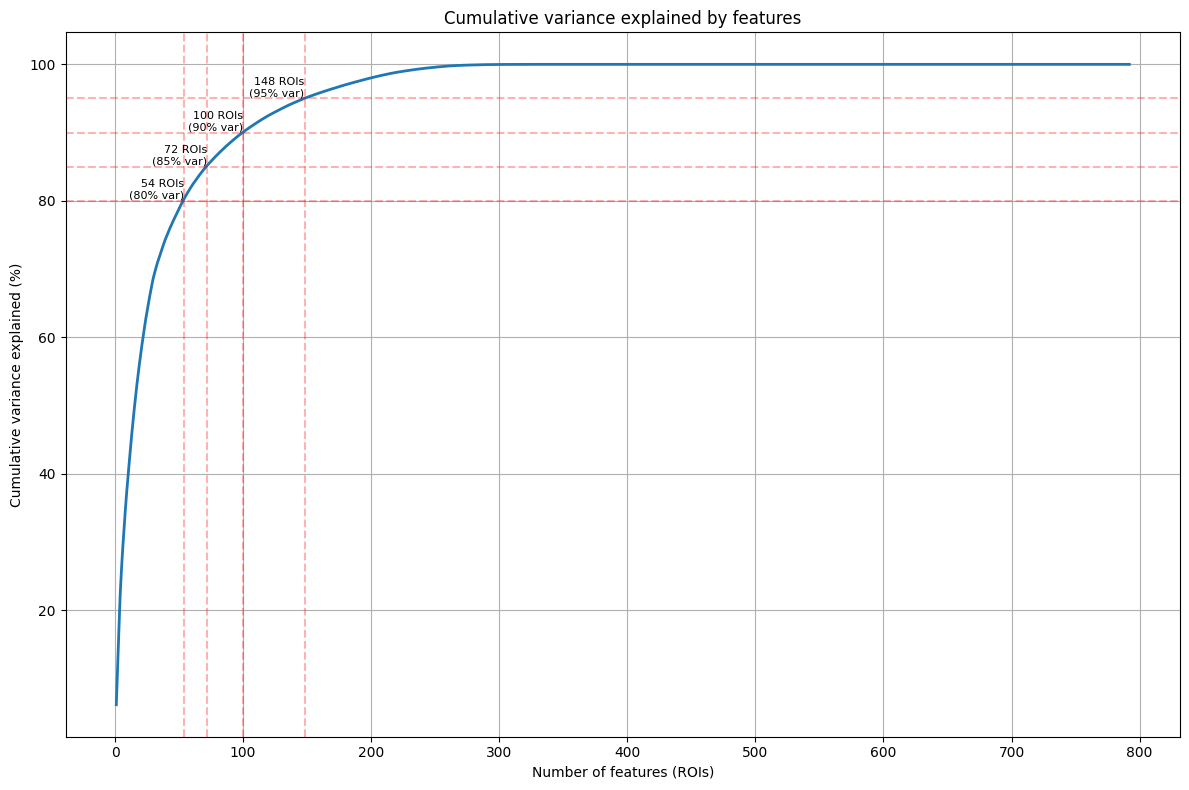


Features needed for variance thresholds:
variance_threshold  n_rois percent_of_total_rois
               50%      16                  2.0%
               60%      22                  2.8%
               70%      32                  4.0%
               80%      54                  6.8%
               85%      72                  9.1%
               90%     100                 12.6%
               95%     148                 18.7%
               99%     226                 28.5%

Detailed variance + ROI names saved to: feature_variance_20250610_125347.xlsx


In [13]:
# cumlative variance 
feature_importance = best_model.named_steps['classifier'].feature_importances_
fnames = np.array(feature_names)
sort_idx = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sort_idx]
sorted_fnames = fnames[sort_idx]
cumulative_variance = np.cumsum(sorted_importance) / sorted_importance.sum() * 100

# plotting
plt.figure(figsize=(12, 8))
plt.plot(
    np.arange(1, len(cumulative_variance) + 1),
    cumulative_variance,
    linewidth=2
)
plt.xlabel('Number of features (ROIs)')
plt.ylabel('Cumulative variance explained (%)')
plt.title('Cumulative variance explained by features')
plt.grid(True)

for threshold in [80, 85, 90, 95]:
    n = np.argmax(cumulative_variance >= threshold) + 1
    plt.axhline(threshold, color='r', linestyle='--', alpha=0.3)
    plt.axvline(n, color='r', linestyle='--', alpha=0.3)
    plt.text(n, threshold, f'{n} ROIs\n({threshold}% var)', ha='right', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# tabulating
variance_df = pd.DataFrame({
    'roi_name': sorted_fnames,
    'importance': sorted_importance,
    'cumulative_variance_%': cumulative_variance
})

# print thresholds
thresholds = [50, 60, 70, 80, 85, 90, 95, 99]
threshold_rows = []
for threshold in thresholds: 
    n = np.argmax(cumulative_variance >= threshold) + 1
    pct = n / len(sorted_importance) * 100
    threshold_rows.append({
        'variance_threshold': f'{threshold}%',
        'n_rois': n,
        'percent_of_total_rois': f'{pct:.1f}%'
    })
threshold_df = pd.DataFrame(threshold_rows)
print("\nFeatures needed for variance thresholds:")
print(threshold_df.to_string(index=False))

# saving to excel
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_file = f'feature_variance_{timestamp}.xlsx'
variance_df.to_excel(out_file, index=False)
print(f"\nDetailed variance + ROI names saved to: {out_file}")

In [14]:
roi_count = variance_df.iloc[:149][['roi_name']]
roi_count['roi_name'] = roi_count['roi_name'].str.replace(r'_Metric0[1-6]$', '', regex=True)
roi_counts = roi_count['roi_name'].value_counts().reset_index()
roi_counts.to_excel('roi_counts.xlsx', index = False)